In [2]:
from shapely.ops import clip_by_rect
from shapely.geometry import Point, Polygon, box
from shapely.affinity import rotate, translate, scale
from shapely.geometry.collection import GeometryCollection
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def three_points_angle(a, b, c):
    v0 = np.array(a) - np.array(b)
    v1 = np.array(c) - np.array(b)

    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return np.around(np.degrees(angle), 5)

def two_points_slope(v0, v1):
    theta = math.atan2(v1[1] - v0[1], v1[0] - v0[0])
    slope = math.degrees(theta)
            
    if slope < 0:
        slope = 360 + slope
        
    return np.around(slope, 5)

def axis_ajust(a,b,c):
    x = False
    y = False
        
    if c[0] > b[0] and a[1] < b[1] or a[1] < b[1] and c[1] > b[1]: # |-
        y = True
                
    if a[0] < b[0] and c[1] < b[1] or a[1] < b[1] and c[0] < b[0]: # -|
        x = True
        y = True
                
    if a[1] > b[1] and c[0] < b[0] or a[0] < b[0] and c[1] > b[1]: # _|
        x = True
        
    return x,y

def pre_process(points):
    data = {}
    for i in range(0, len(points) - 1):
        a = points[i-1]
        b = points[i]
        c = points[i+1]
        if i == 0:       
            a = points[len(points) - 2]
            
        angle = three_points_angle(a,b,c)
        
        if abs(angle) == 90:
            slope = two_points_slope(a,b)
            slope = slope % 90
            data[slope] = []
            
    return data

def get_corners_data(room):
    x, y = room.exterior.xy
    points = list(zip(x,y))
    data = pre_process(points)
    
    for slope in data:
        fig = rotate(room, slope)
        x,y = fig.exterior.xy
        points = list(zip(x,y))
        for i in range(0, len(points) - 1):
            a = points[i-1]
            b = points[i]
            c = points[i+1]
            if i == 0:       
                a = points[len(points) - 2]

            angle = three_points_angle(a,b,c)
            s = two_points_slope(a,b) % 90

            if abs(angle) == 90 and s == 0:
                off_x, off_y = axis_ajust(a,b,c)
                data[slope].append({"reference": np.around(b,5), "x": off_x, "y": off_y})

        
    return data

def normalize(x, y):
    x = np.around(np.array(x) - min(x), 5)
    y = np.around(np.array(y) - min(y),5)
    
    return list(zip(x,y))

In [4]:
ceramic_width = 0.3
ceramic_height = 0.3
spacing = 0.005
total_width = ceramic_width + spacing
total_height = ceramic_height + spacing

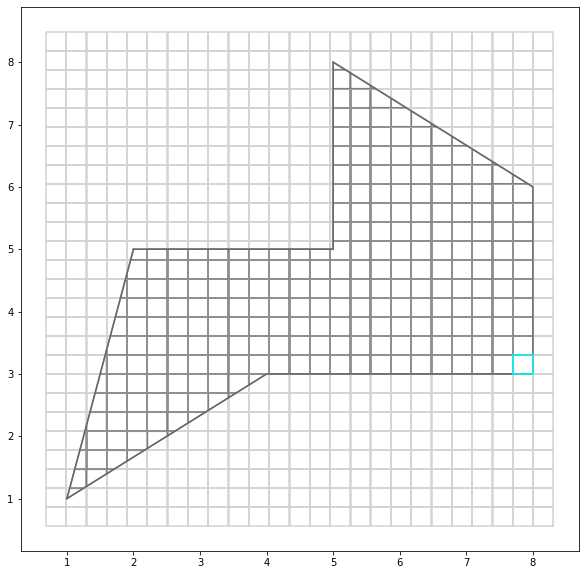

In [5]:
room = Polygon([[1,1],[2,5],[5, 5],[5, 8],[8, 6],[8, 3],[4, 3],[1, 1]])
#room = Polygon([[1,1],[1,5],[9, 5], [9,5],[11, 7],[13, 5],[13, 1],[1, 1]])
#room = Polygon([[1, 1], [0, 1], [0, 4], [2, 4], [2, 2], [4, 2], [4, 0], [1, 0], [1, 1]])
data = get_corners_data(room)

i = 0

result = {}
for slope in data:
    fig = rotate(room, slope)
    xmin, ymin, xmax, ymax = fig.bounds
    
    for corner in data[slope]:
    
        refx, refy = corner["reference"]
        xmin = np.around(xmin - (total_width - (refx - xmin)  % total_width), 5)
        ymin = np.around(ymin - (total_height - (refy - ymin) % total_height), 5)

        plt.figure(i, figsize=(10,10))

        xoff = -0.01 if corner["x"] else 0.01
        yoff = -0.01 if corner["y"] else 0.01

        if not fig.covers(translate(Point((refx,refy)), xoff=xoff, yoff=yoff)):
            continue
        start = None

        fix_x = spacing if corner["x"] else 0
        fix_y = spacing if corner["y"] else 0
        
        result[f"settlement_{i}"] = {"full": 0, "cuts": []}

        for x1 in np.arange(xmin + fix_x, xmax + ceramic_width, total_width):
            for y1 in np.arange(ymin + fix_y, ymax + ceramic_height, total_height):
                x2 = x1 + ceramic_width
                y2 = y1 + ceramic_height
                ceramic = box(
                    np.around(x1, 5),
                    np.around(y1, 5),
                    np.around(x2, 5),
                    np.around(y2, 5))

                x, y = ceramic.exterior.coords.xy
                plt.plot(x,y, color="lightgray")

                if fig.intersects(ceramic) and not ceramic.touches(fig):

                    a, b, c, d = ceramic.bounds
                    c += spacing
                    d += spacing

                    new_ceramic = box(a,b,c,d)

                    if new_ceramic.intersects(Point((refx,refy))):
                        start = ceramic

                    x,y = ceramic.exterior.coords.xy

                    if not fig.covers(ceramic):
                        intersection = fig.intersection(ceramic)
                        if type(intersection) is not Polygon:
                            if type(intersection) is GeometryCollection:
                                for polyg in intersection.geoms:
                                    if type(polyg) is Polygon:
                                        x,y = polyg.exterior.coords.xy
                                        plt.plot(x, y, color="gray")
                        else:
                            x,y = intersection.exterior.xy
                            plt.plot(x, y, color="gray")

                        result[f"settlement_{i}"]["cuts"].append(normalize(x,y))

                    else:
                        plt.plot(x,y, color="gray")
                        result[f"settlement_{i}"]["full"] += 1
        x,y = fig.exterior.xy
        plt.plot(x,y,color="dimgray")

        if start != None:
            x,y = start.exterior.xy
            plt.plot(x,y, color="aqua")
        
        result[f"settlement_{i}"]["slope"] = slope
        result[f"settlement_{i}"]["start"] = start
        

        i += 1

In [6]:
def get_unique_cuts(cuts):
    unique_cuts = []
    for cut in cuts:
        c = Polygon(cut)
        unique = True
        for uc in unique_cuts:
            if c.equals(uc[0]):
                uc[1] += 1
                unique = False
                break
        if unique:
            unique_cuts.append([c, 1])
            
    return unique_cuts

In [7]:
for settlement in result:
    unique_cuts = get_unique_cuts(result[settlement]["cuts"])
    result[settlement]["unique_cuts"] = unique_cuts

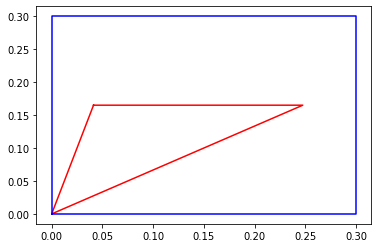

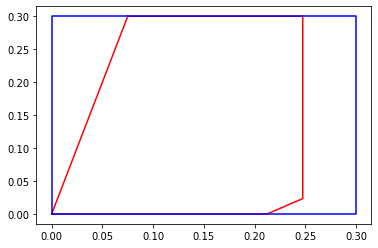

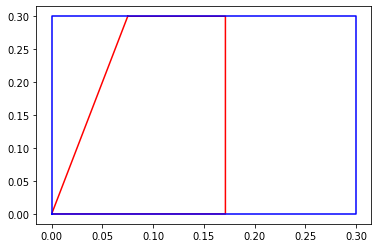

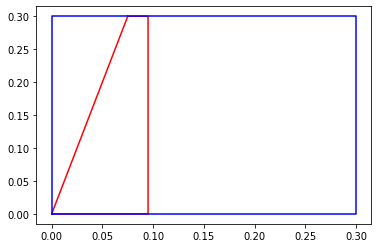

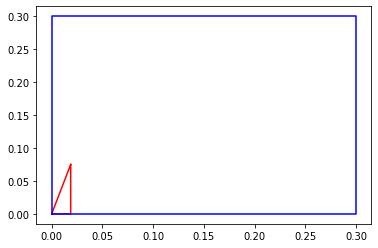

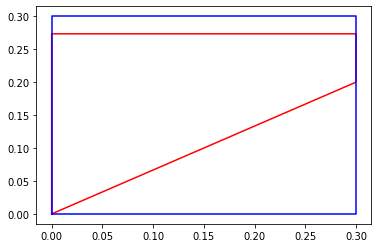

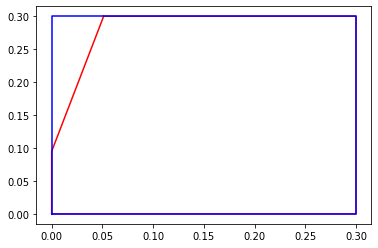

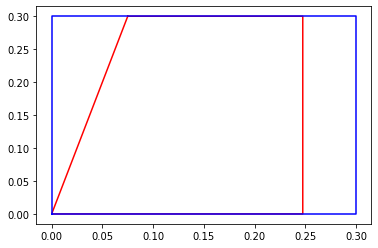

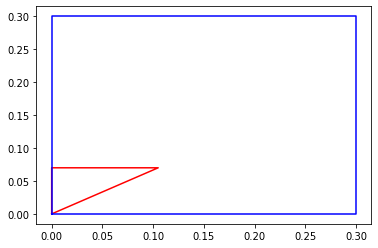

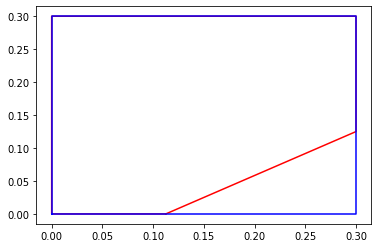

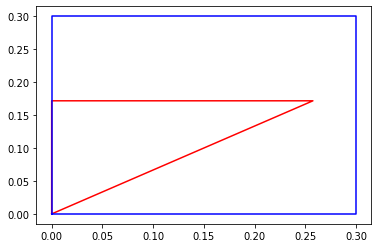

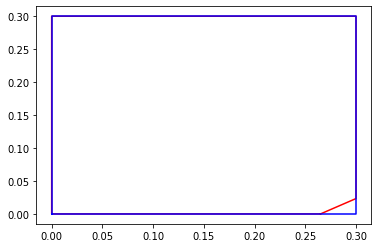

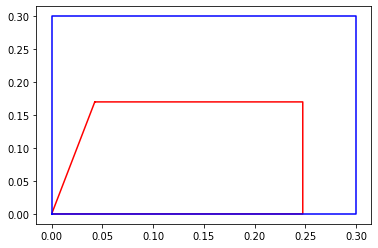

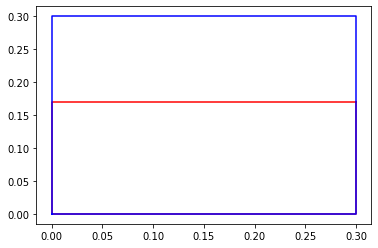

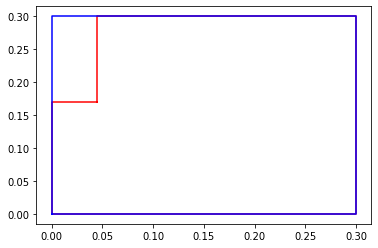

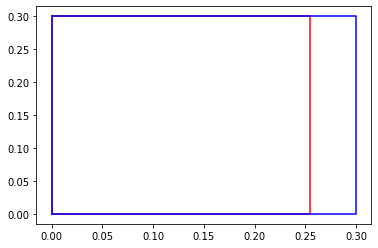

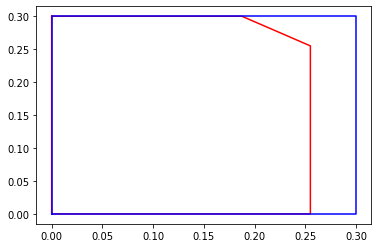

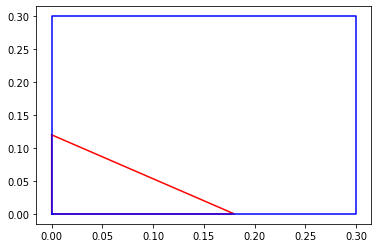

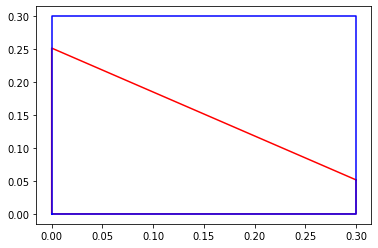

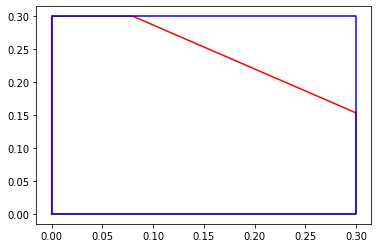

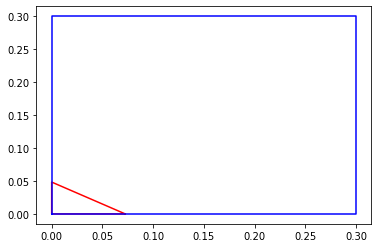

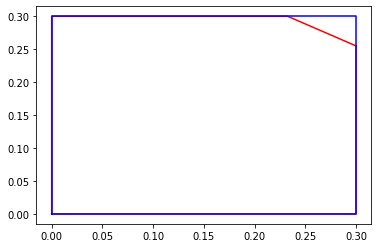

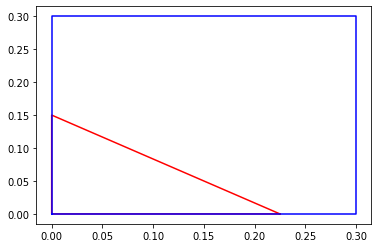

In [20]:
original = Polygon([[0,0],[0,0.3],[0.3, 0.3],[0.3, 0],[0, 0]])
x_original, y_original = original.exterior.xy
for pair in result[settlement]["unique_cuts"]:
    x,y = pair[0].exterior.xy
    plt.plot(x,y, color="red")
    plt.plot(x_original, y_original, color="blue")
    plt.show()


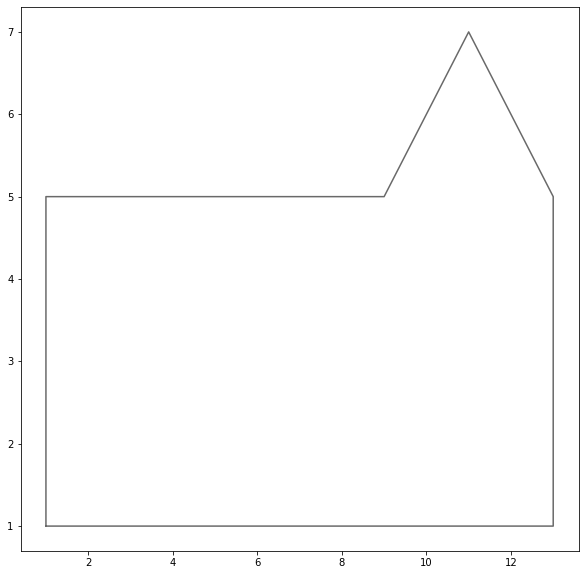

{0.0: [{'reference': array([1., 1.]), 'x': False, 'y': False}, {'reference': array([1., 5.]), 'x': False, 'y': True}, {'reference': array([13.,  1.]), 'x': True, 'y': False}], 45.0: [{'reference': array([7.70711, 8.94975]), 'x': False, 'y': True}]}


In [24]:
#room = Polygon([[1,1],[2,5],[5, 5],[5, 8],[8, 6],[8, 3],[4, 3],[1, 1]])
room = Polygon([[1,1],[1,5],[9, 5], [9,5],[11, 7],[13, 5],[13, 1],[1, 1]])
#room = Polygon([[1, 1], [0, 1], [0, 4], [2, 4], [2, 2], [4, 2], [4, 0], [1, 0], [1, 1]])
data = get_corners_data(room)

plt.figure(i, figsize=(10,10))
x,y = room.exterior.xy
plt.plot(x,y,color="dimgray")
plt.show()


print(data)

Fluxo:

Achar todas as quinas de 90 graus do polígono de entrada

Pra cada quina executar o preview de cortes de cerâmica -> Posteriormente esse algoritmo vira o algoritmo de otimização para escolher o melhor lugar para começar o assentamento

Dado o ponto de escolha, iniciar o assentamento;

Filtrar os cortes únicos